Allen Minch, Marco Qin, and Taku Hagiwara

# Part 1


In [1]:
# import the dataset and matplotlib and numpy

from keras.datasets import boston_housing
import matplotlib.pyplot as plt
import numpy as np
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


The idea of this task is to improve the fit by first clustering the data, and training separate linear models on each cluster (instead of using a single linear model on the entire dataset).

(i) Use ridge regression as a baseline model: train a ridge regression model on the training data, and evaluate the mean squared error on the test data.

In [2]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge = Ridge()
# Ridge regression on the x training data and the y training data as a whole
ridge.fit(x_train, y_train)
# Use the regression to predict y for all of the x in the test set
y_pred = ridge.predict(x_test)
# calculate the mean squared error of y_pred relative to y_test and output the result
print("Ridge regression MSE: ", mean_squared_error(y_test, y_pred))

Ridge regression MSE:  22.548158689769746


(ii) Now use k-means clustering to cluster the training data, using only the inputs x_train for the clustering and not the labels y_train. The reason we cluster using on the inputs is that we will want a model that can make predictions based only on test inputs x_test, without first seeing the labels y_test. Use k = 3 clusters. Visualize the clusters by projecting the data onto the plane and using a scatter plot (e.g. by plotting the first two variables of each data point).

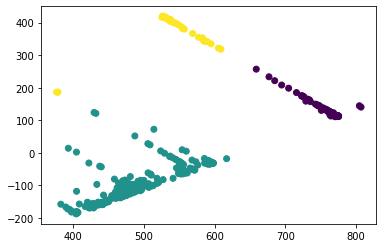

In [3]:
# This cell makes 3 clusters of the data points in x_train and visualizes the data with the clusters using the SVD (just for good practice)
# The next cell does a straight-up projection of the data onto the plane
from sklearn.cluster import KMeans

# perform k-means clustering with three clusters on the training data
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(x_train)
# Use the first two components of the SVD of the training set to visualize the data with 3 clusters
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
svd.fit(x_train)
x_train_svd = svd.transform(x_train)
plt.scatter(x_train_svd[:,0], x_train_svd[:,1], c=kmeans.labels_)
plt.show()

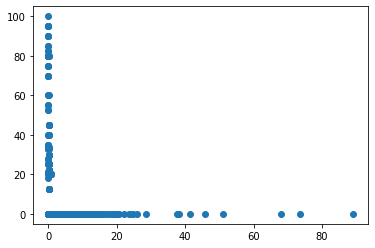

In [4]:
# The above cell used the SVD to visualize the data; this cell now simply plots the first two variables of each data point in the training set
# to visualize the data
plt.scatter(x_train[:,0],x_train[:,1])

(iii) Train three separate ridge regression models T1,T2,T3 , one for each cluster, with each model trained using only the data from the corresponding cluster. What is the total mean squared error on the test data clustered using the same centroids found for the training data?

In [5]:
# This cell presents streamlined and generalized code for solving the task of part (iii) of Part 1

# Determines, for a general number of clusters, the model that is to be used to predict y for each point in x_test
# Takes in the KMeans object associated with the clustering of x_train as a parameter
def get_models(kmeans, num):
  # ith row of distances will represent the distances from the ith test data point to each of the num cluster centers of the training set
  distances = np.zeros((len(x_test), num))
  # compute the distances
  for i in range(len(x_test)):
    for j in range(num):
      distances[i][j] = np.linalg.norm(x_test[i] - kmeans.cluster_centers_[j])
  modelsToUse = np.zeros(len(x_test))
  # for each test data point, choose which model to use to predict y based on whichever training cluster center is closest to the test data point
  for i in range(len(x_test)): 
    modelsToUse[i] = np.argmin(distances[i])  
  return modelsToUse

# Kmeans is a KMeans object, designed to have a number of clusters equal to num
# Num essentially represents the number of clusters that the training data are clustered into
# this function assumes having access to x_train, y_train, x_test, and y_test
def total_mse(kmeans, num):
  # decide which model to make a prediction for each point in x_test
  models = get_models(kmeans, num)
  total = 0
  # this for loop essentially loops through each cluster of the training set
  for i in range(num):
    # generate a Ridge object
    ridge = Ridge()
    # train it only using data from the training cluster with label i, using boolean indexing to get access to all such data
    ridge.fit(x_train[kmeans.labels_==i], y_train[kmeans.labels_==i])
    # using the trained model, make predictions for y corresponding to each point in x_test for which the model is supposed to be used
    y_pred = ridge.predict(x_test[models==i])
    # get the true values of y corresponding to the given points in x_test
    y_true = y_test[models == i]
    # add all of the squared errors in the predictions made using model i (the model trained using data in the cluster with label i)
    for j in range(len(y_true)):
      total+= (np.linalg.norm(y_true[j] - y_pred[j]))**2
  return total/len(x_test)

# calculate the mean squared error when 3 clusters are used
print(total_mse(kmeans, 3))

15.006352078682507


# Start of Part 2

In the scatter plot below, we plotted the same database but with 4 clusters instead of 3. We want to see if splitting it into 4 clusters instead of 3 clusters will improve the MSE as we saw in part (iii) of part 1.

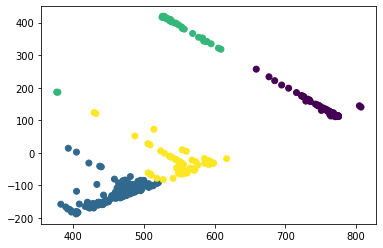

14.566458977028002


In [6]:
# This cell makes 4 clusters of the data points in x_train and visualizes the data with the clusters using the SVD

from sklearn.cluster import KMeans
# perform k-means clustering with four clusters on the training data
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(x_train)
y_pred = kmeans.predict(x_test)
# # Use the first two components of the SVD of the training set to visualize the data with 3 clusters
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3)
svd.fit(x_train)
x_train_svd = svd.transform(x_train)
x_test_svd = svd.transform(x_test)
plt.scatter(x_train_svd[:,0], x_train_svd[:,1], c=kmeans.labels_)
plt.show()

# see what the mean squared error is using 4 clusters in the training set
print(total_mse(kmeans, 4))

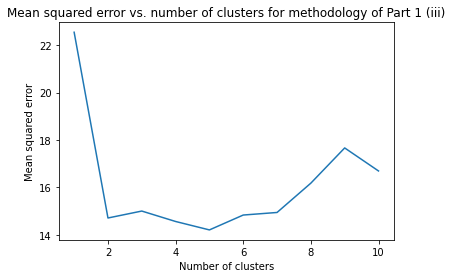

In [7]:
# this cell computes the mean squared error using the methodology of part (iii) of Part 1
# using numbers of clusters in the range from 1 to 10, going beyond just 3 or 4 clusters

# make the computations
MSElist = []
for i in range(1, 11):
  kmeanModel = KMeans(i)
  kmeanModel.fit(x_train)
  MSElist.append(total_mse(kmeanModel, i))
# plot the results
plt.xlabel("Number of clusters")
plt.ylabel("Mean squared error")
plt.title("Mean squared error vs. number of clusters for methodology of Part 1 (iii)")
plt.plot(range(1,11),MSElist)

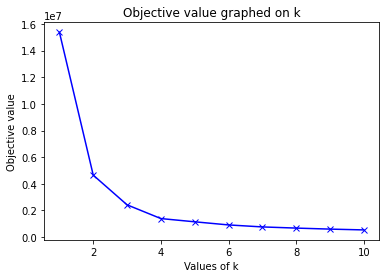

In [8]:
# this cell explores using the elbow method to decide what the best number of clusters would be for the data set we are given

# compute the objective value associated with using each number of clusters from 1 to 10 to cluster x_train
obj_val=[]
for k in range(1,11):
  kmeanModel=KMeans(k)
  kmeanModel.fit(x_train)
  obj_val.append(kmeanModel.inertia_)

# plot the results
plt.plot(range(1,11),obj_val, 'bx-')
plt.xlabel('Values of k')
plt.ylabel('Objective value')
plt.title("Objective value graphed on k")
plt.show()